In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
B = 1
N = 50
I = 18
mu = 2.08
S = 0.015
m = 8
r = 0.107

In [3]:
def delta(omega, t, i):
    value = omega*t + np.pi/2 + ((i - 1)*4*np.pi/6)
    return ((-np.pi*6 <= value) & (value <= 7*np.pi/6)).astype(int)

In [4]:
def torque(t, omega):
    return (-B*N*I*mu*S*(
        delta(omega, t, 1)*np.sin(omega*t + np.pi/2)
        + delta(omega, t, 2)*np.sin(omega*t + 7*np.pi/6)
        + delta(omega, t, 3)*np.sin(omega*t + 11*np.pi/6)
    ) - 10*r*m*(np.cos(omega*t + np.pi/2) + np.cos(omega*t + 7*np.pi/6) + np.cos(omega*t + 11*np.pi/6)))

In [5]:
def domega_dt(t, omega):
    return torque(t, omega)/(3*m*(r**2))

In [6]:
t = np.linspace(0, 120, 1000)

In [7]:
omega = solve_ivp(domega_dt, [0, 120], np.array([-0.734]), t_eval=t).y[0]

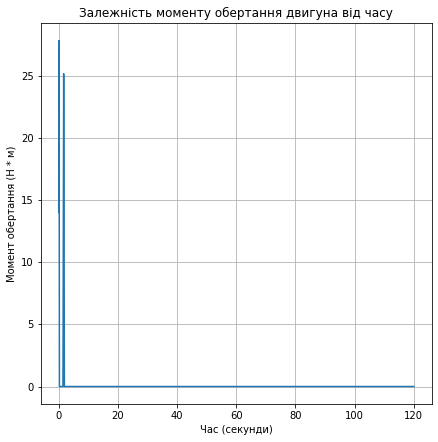

In [19]:
plt.figure(figsize=(7, 7))
plt.title("Залежність моменту обертання двигуна від часу")
plt.xlabel("Час (секунди)")
plt.ylabel("Момент обертання (Н * м)")
plt.grid()
plt.plot(t, -torque(t, omega))

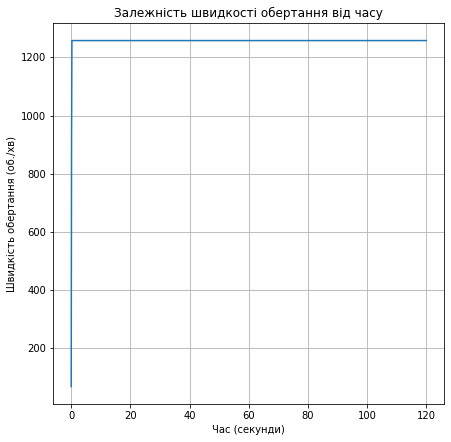

In [22]:
plt.figure(figsize=(7, 7))
plt.title("Залежність швидкості обертання від часу")
plt.xlabel("Час (секунди)")
plt.ylabel("Швидкість обертання (об./хв)")
plt.grid()
plt.plot(t, -(omega/2*np.pi)*60)